### signifigant pcs: Per cluster, how many signifigant PCs do you find? 

signifigant defined via Optimal Singular Value Hard Threshold

code from https://humaticlabs.com/blog/optimal-svht/ 
also this R implementation https://rdrr.io/github/kevinblighe/PCAtools/src/R/randomMethods.R


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
import scipy as sp
from scipy.stats import linregress, chisquare, ttest_rel, ranksums
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, diag, exp, real, sin, cosh, tanh
from scipy.linalg import svd, svdvals

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *


# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

In [3]:
# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

In [ ]:
def omega_approx(beta):
    """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

def svht(X, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""
    
    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sv is None:
        sv = svdvals(X)
    sv = np.squeeze(sv)
    if sv.ndim != 1:
        raise ValueError('vector of singular values must be 1-dimensional')
    return np.median(sv) * omega_approx(beta)


def num_pcs_above_cutoff(cluster_values):
    "count the number of pcs that are signifignat"
    sv = svdvals(cluster_values)
    tau = svht(cluster_values, sv=sv)
    return sum(sv > tau)

In [5]:
clusters_across_tissues = []
for tissue_id in tissue_ids:
    # load in data for this tissue
    expression = pd.read_csv(f"output/proteincoding_main/clusters_expression/{tissue_id}.v8.normalized_residualized_expression.cluster_genes.bed", sep='\t')
    sample_ids = expression.columns[4:]

    expression['egene_id'] = expression['gene_id'].str.split('_e_').str[1]
    expression['cluster_id'] = expression['gene_id'].str.split('_e_').str[0]
    expression_df_gid = expression.set_index('egene_id')
    clusters = load_cluster(config, tissue_id)

    # annotated each cluster with the number of signifigant pcs
    for idx, row in tqdm(clusters.iterrows(), total=len(clusters)):
        # get the gene expresion for genes in this cluster
        cluster_expression_df_gid = expression_df_gid[expression_df_gid['cluster_id']==row['cluster_id']]
        cluster = cluster_expression_df_gid.loc[row['Transcripts'].split(',')]

        X = cluster[sample_ids].transpose()
        num_pcs = num_pcs_above_cutoff(X)
        clusters.loc[idx, 'num_signifigant_pcs'] = num_pcs

    clusters_across_tissues.append(clusters)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 883/883 [00:01<00:00, 460.33it/s]


<AxesSubplot: xlabel='N_genes', ylabel='num_signifigant_pcs'>

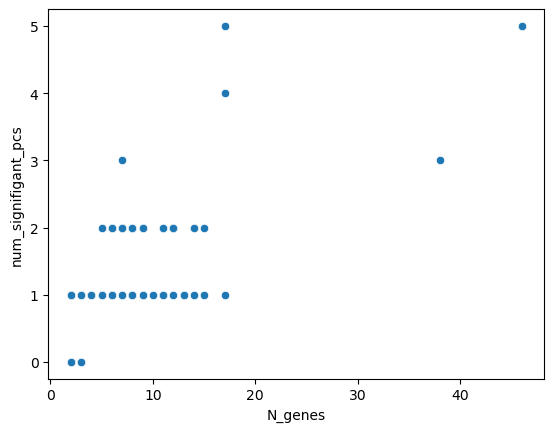

In [6]:
clusters_annotated = pd.concat(clusters_across_tissues)
clusters_annotated['tissue_id'] = clusters_annotated['Tissue']
sns.scatterplot(clusters_annotated, x='N_genes', y='num_signifigant_pcs')

In [7]:
# load in the pc credible sets and see if each is signifigant
pc_susie = load_across_tissues(config, load_pc_susie_r)
pc_susie = pd.merge(pc_susie, clusters_annotated[['cluster_id', 'tissue_id',  'num_signifigant_pcs']], on=['cluster_id', 'tissue_id'], how='left')
pc_susie = pc_susie.drop_duplicates(['cs_id'])
pc_susie['is_sig'] = (pc_susie['pc_num'] <= pc_susie['num_signifigant_pcs'])

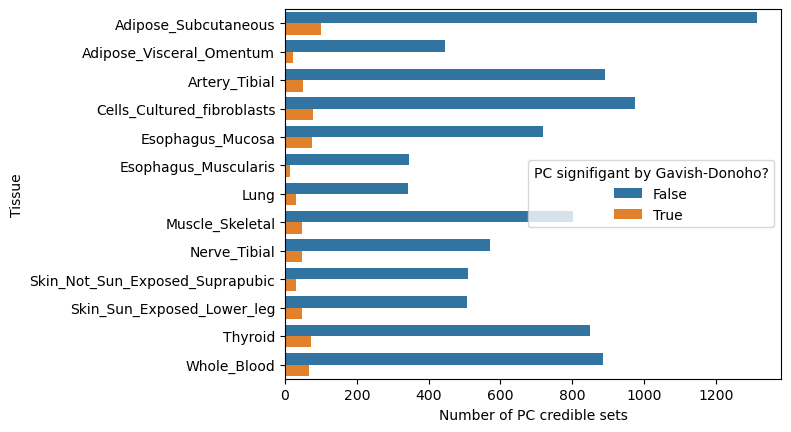

In [11]:
ax = sns.countplot(pc_susie, y='tissue_id', hue='is_sig')
ax.set_xlabel("Number of PC credible sets")
ax.set_ylabel("Tissue")
# Change legend title
leg = ax.get_legend()
leg.set_title('PC signifigant by Gavish-Donoho?')



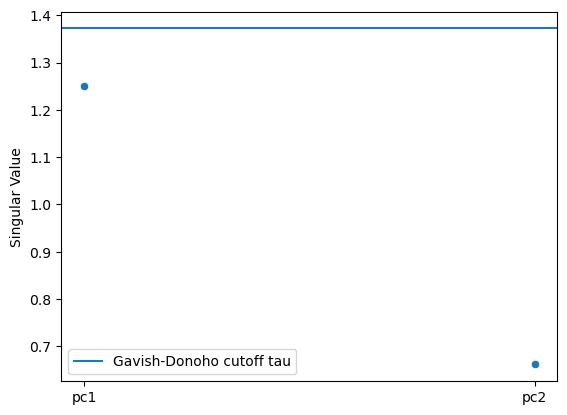

In [ ]:
# example of sv and plot
X = 
sv = svdvals(X)
tau = svht(X, sv=sv)
ax = sns.scatterplot(sv)
ax.axhline(tau, label='Gavish-Donoho cutoff tau')
ax.set_xticks(ticks = range(len(cluster)), labels=[f'pc{i+1}' for i in range(len(cluster))])
ax.set_ylabel('Singular Value')
plt.legend()
plt.show()
